<a href="https://colab.research.google.com/github/anjanavasudevan/Thesis/blob/main/Quadrotor_simulation/controllers/DeepRL/SAC_Hover_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import argparse
import pickle
from collections import namedtuple
from itertools import count

import os
import numpy as np


import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import grad
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
#from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

import pickle

In [90]:
from hover_state_space import hover_state_space
env = hover_state_space()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [91]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_dim

4

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [93]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)

        return action

    def _reverse_action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)

        return action


env = NormalizedActions(env)

In [94]:
tau = 0.005
target_update_interval = 1
gradient_steps = 1
lr = 3e-4
gamma = 0.99
capacity = 10000
iteration = 1000
batch_size = 64
num_hidden_layers = 2
num_hidden_units_per_layer = 128
sample_frequency = 256
activation = 'Relu'
log_interval = 2000

max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float()
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_', 'd'])

In [95]:
class Actor(nn.Module):
    def __init__(self, state_dim, min_log_std=-20, max_log_std=2):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu_head = nn.Linear(256, 4)
        self.log_std_head = nn.Linear(256, 4)
        self.max_action = max_action

        self.min_log_std = min_log_std
        self.max_log_std = max_log_std

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)
        log_std_head = F.relu(self.log_std_head(x))
        log_std_head = torch.clamp(log_std_head, self.min_log_std, self.max_log_std)
        return mu, log_std_head

In [96]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [97]:
class Q(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, s, a):
        #print(s.shape, a.shape)
        #s = s.reshape(-1, state_dim)
        #print(s.shape)
        #print(a)
        a = a.reshape(-1, action_dim)
        #print(a.shape)
        x = torch.cat([s, a], -1) # combination s and a
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [98]:
class SAC():
    def __init__(self):
        super(SAC, self).__init__()

        self.policy_net = Actor(state_dim).to(device)
        self.value_net = Critic(state_dim).to(device)
        self.Q_net = Q(state_dim, action_dim).to(device)
        self.Target_value_net = Critic(state_dim).to(device)

        self.replay_buffer = [Transition] * capacity
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)
        self.Q_optimizer = optim.Adam(self.Q_net.parameters(), lr=lr)
        self.num_transition = 0 # pointer of replay buffer
        self.num_training = 1
        #self.writer = SummaryWriter('./exp-SAC')

        self.value_criterion = nn.MSELoss()
        self.Q_criterion = nn.MSELoss()

        for target_param, param in zip(self.Target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)

        os.makedirs('./SAC_model/', exist_ok=True)

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        mu, log_sigma = self.policy_net(state)
        sigma = torch.exp(log_sigma)
        dist = Normal(mu, sigma)
        z = dist.sample()
        action = torch.tanh(z).detach().cpu().numpy()
        return action # return a scalar, float32

    def store(self, s, a, r, s_, d):
        index = self.num_transition % capacity
        #print("Action shape: ", a.shape)
        transition = Transition(s, a, r, s_, d)
        self.replay_buffer[index] = transition
        self.num_transition += 1

    def get_action_log_prob(self, state):

        batch_mu, batch_log_sigma = self.policy_net(state)
        batch_sigma = torch.exp(batch_log_sigma)
        dist = Normal(batch_mu, batch_sigma)
        z = dist.sample()
        action = torch.tanh(z)
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + min_Val)
        return action, log_prob, z, batch_mu, batch_log_sigma


    def update(self):
        if self.num_training % 500 == 0:
            print("Training ... {} ".format(self.num_training))
        s = torch.tensor(np.array([t.s for t in self.replay_buffer])).float().to(device)
        a = torch.tensor(np.array([t.a for t in self.replay_buffer])).to(device)
        r = torch.tensor(np.array([t.r for t in self.replay_buffer])).to(device)
        s_ = torch.tensor(np.array([t.s_ for t in self.replay_buffer])).float().to(device)
        d = torch.tensor(np.array([t.d for t in self.replay_buffer])).float().to(device)

        for _ in range(gradient_steps):
            #for index in BatchSampler(SubsetRandomSampler(range(args.capacity)), args.batch_size, False):
            index = np.random.choice(range(capacity), batch_size, replace=False)
            #print(s.shape)
            bn_s = s[index]
            #print(a.shape)
            bn_a = a[index].reshape(-1, 1)
            bn_r = r[index].reshape(-1, 1)
            bn_s_ = s_[index]
            bn_d = d[index].reshape(-1, 1)


            target_value = self.Target_value_net(bn_s_)
            next_q_value = bn_r + (1 - bn_d) * gamma * target_value

            excepted_value = self.value_net(bn_s)
            excepted_Q = self.Q_net(bn_s, bn_a)

            sample_action, log_prob, z, batch_mu, batch_log_sigma = self.get_action_log_prob(bn_s)
            excepted_new_Q = self.Q_net(bn_s, sample_action)
            next_value = excepted_new_Q - log_prob

            # !!!Note that the actions are sampled according to the current policy,
            # instead of replay buffer. (From original paper)

            V_loss = self.value_criterion(excepted_value, next_value.detach())  # J_V
            V_loss = V_loss.mean()
            v_loss_copy = V_loss.clone().detach().cpu().numpy()

            # Single Q_net this is different from original paper!!!
            Q_loss = self.Q_criterion(excepted_Q.float(), next_q_value.detach().float()) # J_Q
            Q_loss = Q_loss.mean().float()
            q_loss_copy = Q_loss.clone().detach().cpu().numpy()

            log_policy_target = excepted_new_Q - excepted_value

            pi_loss = log_prob * (log_prob- log_policy_target).detach()
            pi_loss = pi_loss.mean()
            pi_loss_copy = pi_loss.clone().detach().cpu().numpy()

            #self.writer.add_scalar('Loss/V_loss', V_loss, global_step=self.num_training)
            #self.writer.add_scalar('Loss/Q_loss', Q_loss, global_step=self.num_training)
            #self.writer.add_scalar('Loss/pi_loss', pi_loss, global_step=self.num_training)
            # mini batch gradient descent
            self.value_optimizer.zero_grad()
            V_loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
            self.value_optimizer.step()

            self.Q_optimizer.zero_grad()
            Q_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.Q_net.parameters(), 0.5)
            self.Q_optimizer.step()

            self.policy_optimizer.zero_grad()
            pi_loss.backward(retain_graph = True)
            nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
            self.policy_optimizer.step()

            # soft update
            for target_param, param in zip(self.Target_value_net.parameters(), self.value_net.parameters()):
                target_param.data.copy_(target_param * (1 - tau) + param * tau)

            self.num_training += 1
            return v_loss_copy, q_loss_copy, pi_loss_copy

    def save(self):
        torch.save(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.save(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.save(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print("====================================")
        print("Model has been saved...")
        print("====================================")

    def load(self):
        torch.load(self.policy_net.state_dict(), './SAC_model/policy_net.pth')
        torch.load(self.value_net.state_dict(), './SAC_model/value_net.pth')
        torch.load(self.Q_net.state_dict(), './SAC_model/Q_net.pth')
        print()

In [99]:

agent = SAC()
#if args.load: agent.load()
#if args.render: env.render()
print("====================================")
print("Collection Experience...")
print("====================================")

#ep_r = 0
rewards = []
q_loss = []
v_loss = []
pi_loss = []
for i in range(iteration):
  ep_loss = dict(q_loss = [], v_loss = [], pi_loss = [])
  ep_r = 0
  state = env.reset()
  for t in range(200):
    action = agent.select_action(state)
    #print("Action shape", action.shape)
    next_state, reward, done = env.step(action)
    ep_r += reward
    #if args.render: env.render()
    agent.store(state, action, reward, next_state, done)

    if agent.num_transition >= capacity:
      q_l, v_l, pi_l = agent.update()
      ep_loss['q_loss'].append(float(q_l))
      ep_loss['v_loss'].append(float(v_l))
      ep_loss['pi_loss'].append(float(pi_l))

    state = next_state
    if done or t == 199:
      if i % 20 == 0:
        print("Ep_i {}, the ep_r is {}, the t is {}".format(i, ep_r, t))
        break
  if i % log_interval == 0:
    agent.save()
  #agent.writer.add_scalar('ep_r', ep_r, global_step=i)
  #agent.writer.add_scalar('Episode_q_loss', np.mean(ep_loss['q_loss']), global_step=i)
  #agent.writer.add_scalar('Episode_v_loss', np.mean(ep_loss['v_loss']), global_step=i)
  #agent.writer.add_scalar('Episode_pi_loss', np.mean(ep_loss['pi_loss']), global_step=i)
        
  rewards.append(ep_r)
  q_loss.append(np.mean(ep_loss['q_loss']))
  v_loss.append(np.mean(ep_loss['v_loss']))
  pi_loss.append(np.mean(ep_loss['pi_loss']))

Collection Experience...
Ep_i 0, the ep_r is -11624.684025995652, the t is 199
Model has been saved...


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep_i 20, the ep_r is -6553.809459206724, the t is 199
Ep_i 40, the ep_r is -9660.900106177303, the t is 199


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 4])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training ... 500 
Training ... 1000 
Training ... 1500 
Training ... 2000 
Ep_i 60, the ep_r is -12843.619592600611, the t is 199
Training ... 2500 
Training ... 3000 
Training ... 3500 
Training ... 4000 
Training ... 4500 
Training ... 5000 
Training ... 5500 
Training ... 6000 
Ep_i 80, the ep_r is -1904.5465126778033, the t is 199
Training ... 6500 
Training ... 7000 
Training ... 7500 
Training ... 8000 
Training ... 8500 
Training ... 9000 
Training ... 9500 
Training ... 10000 
Ep_i 100, the ep_r is -2875.924235787736, the t is 199
Training ... 10500 
Training ... 11000 
Training ... 11500 
Training ... 12000 
Training ... 12500 
Training ... 13000 
Training ... 13500 
Training ... 14000 
Ep_i 120, the ep_r is -947.0357072903449, the t is 199
Training ... 14500 
Training ... 15000 
Training ... 15500 
Training ... 16000 
Training ... 16500 
Training ... 17000 
Training ... 17500 
Training ... 18000 
Ep_i 140, the ep_r is -825.8961688523301, the t is 199
Training ... 18500 
Train

In [100]:
a = torch.Tensor([[ 0.8846],
        [-0.7883],
        [-0.7953],
        [-0.1356],
        [-0.3132],
        [ 0.2543],
        [ 0.1001],
        [ 0.3229],
        [-0.0241],
        [ 0.7039],
        [-0.0283],
        [ 0.3579],
        [ 0.3291],
        [-0.7184],
        [-0.4124],
        [ 0.4838],
        [-0.2666],
        [-0.5899],
        [-0.9577],
        [-0.5541],
        [ 0.9838],
        [-0.3028],
        [-0.8259],
        [-0.8602],
        [-0.7234],
        [ 0.1965],
        [-0.0496],
        [-0.1460],
        [-0.0028],
        [ 0.5260],
        [ 0.6380],
        [-0.8950],
        [ 0.4189],
        [-0.6324],
        [-0.6256],
        [-0.7158],
        [-0.9768],
        [-0.9586],
        [-0.7450],
        [-0.9746],
        [ 0.3168],
        [-0.1032],
        [ 0.0153],
        [ 0.4876],
        [ 0.4393],
        [ 0.7463],
        [-0.7817],
        [-0.9114],
        [-0.0041],
        [-0.4704],
        [-0.9687],
        [ 0.7959],
        [-0.7933],
        [-0.9439],
        [-0.8123],
        [ 0.7601],
        [-0.9367],
        [ 0.0550],
        [ 0.6610],
        [-0.6241],
        [ 0.2836],
        [-0.9984],
        [ 0.3965],
        [-0.3901]])
a.shape

torch.Size([64, 1])

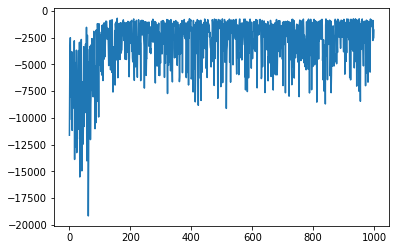

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rewards)